# Terrascope STAC API advanced: Port of Antwerp

In this notebook, we demonstrate how to use the Terrascope STAC API to create a GIF of Sentinel-1 Sigma0 backscatter imagery, over the Port of Antwerp.

We'll leverage two STAC-focused Python libraries:

1. `pystac-client` – to query the STAC catalog and retrieve relevant Sentinel-1 Sigma0 products.

2. `stackstac` – to load and prepare the data for visualization.

What this notebook does:

1. Define and visualize an area of interest (AOI).

2. Use the Terrascope STAC API to search for matching Sentinel-1 Sigma0 scenes.

3. Use stackstac to read the found items.

4. Create a GIF to visualize results.

Sources: https://stackstac.readthedocs.io/en/latest/basic.html 

In [1]:
import pystac_client
import stackstac
import dask.diagnostics
import geogif
from shapely import wkt
from shapely.geometry import mapping, box
from shapely.ops import transform
from ipyleaflet import Map, WKTLayer
from pyproj import Transformer

### Defining the AIO

Lets start by defining the area of interest. We can define this as a WKT polygon.

In [2]:
aio= "POLYGON ((-355.819702 51.232688, -355.58075 51.232688, -355.58075 51.32203, -355.819702 51.32203, -355.819702 51.232688))"
# Convert WKT string to a shapely geometry
wkt_aio = wkt.loads(aio)

To give you a better idea how our final plot will look like, we can plot this area of interest using Ipyleaflet.

In [3]:
# Center the map on the polygon
centroid = wkt_aio.centroid
m = Map(center=(centroid.y, centroid.x), zoom=10)
# Add the AIO to the map
m.add(WKTLayer(
    wkt_string=aio,
))
m

Map(center=[51.277359000000004, -355.70022600000004], controls=(ZoomControl(options=['position', 'zoom_in_text…

### Query the catalog

Now that we have our area of interest for the Port of Antwerp, we can query the STAC API to find Sigma0 images over this area. 

In [4]:
URL = "https://stac-api.vgt.vito.be"
catalog = pystac_client.Client.open(URL)

In [6]:
items = catalog.search(
    intersects=wkt_aio,
    collections=["terrascope-s1-grd-sigma0-v1"],
    datetime="2025-06-01/2025-07-01"
).item_collection()
len(items)

10

### Using the stackstac libary

The stackstac library allows us to convert a STAC collection into a lazy xarray.DataArray, enabling efficient computations on raster data such as mosaics, temporal composites, and other aggregations. We'll use stackstac to prepare our data stack and generate the final visualization.

Before we load the data, we need to update the metadata of the STAC items. Each STAC asset includes an href, which points to the remote location of the file. However, if we have a local copy of the data, we can improve performance by overriding the default href with an alternative path from the asset’s alternate links. This allows stackstac to load the data directly from disk instead of downloading it.

In [7]:
# Replace asset hrefs with local paths
for item in items:
    for asset in item.assets.values():
        if 'alternate' in asset.extra_fields:
            alt = asset.extra_fields['alternate']
            if 'local' in alt and 'href' in alt['local']:
                # Override the default href with the local one
                asset.href = alt['local']['href']

Now we can create the lazy xarray.DataArray.

In [8]:
stack = stackstac.stack(items, assets=["VV",
                                       "VH",
                                      ], epsg=32631,
                        resolution=20)
stack

<xarray.DataArray 'stackstac-dfd5aa62deba393fdf5d830bb067d58e' (time: 10,
                                                                band: 2,
                                                                y: 16877,
                                                                x: 23292)> Size: 63GB
dask.array<fetch_raster_window, shape=(10, 2, 16877, 23292), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/41)
  * time                         (time) datetime64[ns] 80B 2025-06-03T17:24:5...
    id                           (time) <U62 2kB 'S1A_IW_GRDH_SIGMA0_DV_20250...
  * band                         (band) <U2 16B 'VV' 'VH'
  * x                            (x) float64 186kB 3.988e+05 ... 8.647e+05
  * y                            (y) float64 135kB 5.866e+06 ... 5.529e+06
    processing:facility          <U4 16B 'VITO'
    ...                           ...
    description                  (band) <U157 1kB 'Calibrated radar backscatt...
    unit                         <U5 20B 'unity'
    bands                        (band) object 16B {'name': 'VV'} {'name': 'VH'}
    raster:offset                float64 8B 0.0
    nodata                       <U3 12B 'nan'
    epsg                         int64 8B 32631
Attributes:
    spec:        RasterSpec(epsg=32631, bounds=(398840, 5528780, 864680, 5866...
    crs:         epsg:32631
    transform:   | 20.00, 0.00, 398840.00|\n| 0.00,-20.00, 5866320.00|\n| 0.0...
    resolution:  20

This already gives us a lot of useful information including the shape of the arrays, their size, data types, and more. One thing you might notice is that the full dataset is almost 50 GB! That could be a problem, but luckily, we don’t need all of it, we're only interested in the area above the Port of Antwerp. Let’s create a new array that contains just that region.

In [9]:
# Reproject to EPSG:32631 (the EPSG of the collection
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32631", always_xy=True)
transformed_aoi = transform(transformer.transform, wkt_aio)

# Get bounds
minx, miny, maxx, maxy = transformed_aoi.bounds

# Use with stack.loc
stack_aoi = stack.loc[dict(
    x=slice(minx, maxx),
    y=slice(maxy, miny)  # y axis goes from top to bottom
)]
stack_aoi

<xarray.DataArray 'stackstac-dfd5aa62deba393fdf5d830bb067d58e' (time: 10,
                                                                band: 2,
                                                                y: 511, x: 842)> Size: 69MB
dask.array<getitem, shape=(10, 2, 511, 842), dtype=float64, chunksize=(1, 1, 282, 797), chunktype=numpy.ndarray>
Coordinates: (12/41)
  * time                         (time) datetime64[ns] 80B 2025-06-03T17:24:5...
    id                           (time) <U62 2kB 'S1A_IW_GRDH_SIGMA0_DV_20250...
  * band                         (band) <U2 16B 'VV' 'VH'
  * x                            (x) float64 7kB 5.823e+05 ... 5.991e+05
  * y                            (y) float64 4kB 5.687e+06 ... 5.676e+06
    processing:facility          <U4 16B 'VITO'
    ...                           ...
    description                  (band) <U157 1kB 'Calibrated radar backscatt...
    unit                         <U5 20B 'unity'
    bands                        (band) object 16B {'name': 'VV'} {'name': 'VH'}
    raster:offset                float64 8B 0.0
    nodata                       <U3 12B 'nan'
    epsg                         int64 8B 32631
Attributes:
    spec:        RasterSpec(epsg=32631, bounds=(398840, 5528780, 864680, 5866...
    crs:         epsg:32631
    transform:   | 20.00, 0.00, 398840.00|\n| 0.00,-20.00, 5866320.00|\n| 0.0...
    resolution:  20

We can now see that we've reduced the dataset size from 80 GB to just 80 MB!
At this point, we still haven’t loaded the actual data into memory since stack_aoi is a lazy xarray.DataArray. Stackstac uses Dask for this.

In [10]:
with dask.diagnostics.ProgressBar():
    data = stack_aoi.compute()

[########################################] | 100% Completed | 10.78 s


According to the output of stack_aoi, we have a time series of 12 images, each with a resolution of 842 × 511 pixels. We’ll use the geogif package to visualize this time series. This package can turn an xarray.DataArray into an animated GIF. For this visualization, we’ll select a single band from the dataset.

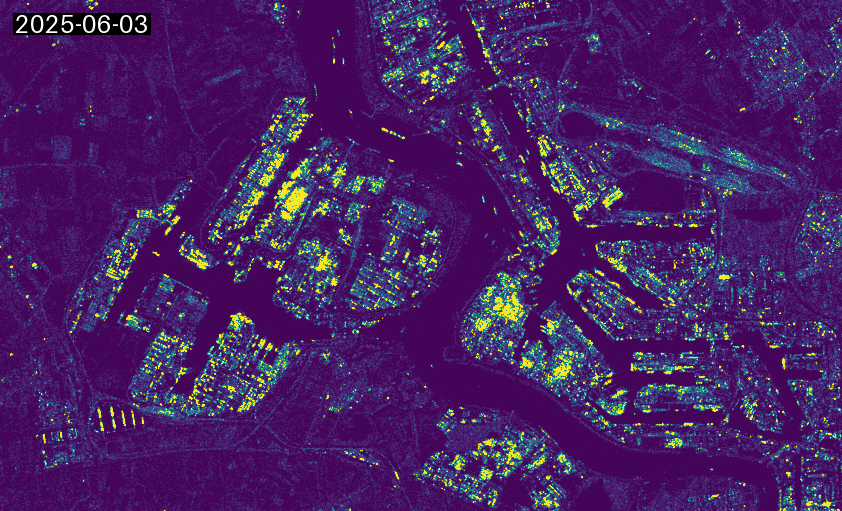

In [11]:
data_single_band = data.sel(band="VH")
gif = geogif.gif(data_single_band, fps=1)
gif